### Import data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo


import sys
import os
sys.path.append(os.path.abspath(".."))  # Subir un nivel para encontrar src si está en Isolated_Observations
sys.path.append(os.path.abspath("./src"))  # Alternativamente, busca src en la misma carpeta

from src.data_processing import extract_features
from src.model import  self_calculate_bartlett_sphericity


# Cargar el archivo en un DataFrame
data_path = "../data/"

#dataset ='Automatic_Labeling_Kyoogu/'
#dataset ='Dataset_1/'
dataset ='Dataset_2/'

file = 'Labeled_Data_With_FCCs.xlsx'
df = pd.read_excel(data_path+dataset+file)

columns_to_remove = ['Month', 'Day', 'Hour', 'Length', 'Minute', 'Fmin', 'Fmax', 'View', 'Channel']  

# Remove columns from data frame
df = df.drop(columns_to_remove, axis=1, errors='ignore')
df.head()

FS = 48000

## Manual extraction of Spectral Features and concatenation with previous features 

In [2]:
# Calculate features for each segment
# Write the path of the DB
audio_path = "../audios/"
if dataset == 'Dataset_2/':
    prefix = audio_path + dataset    
else:
    prefix = audio_path + 'Dataset_1/'   
#prefix = 'C:/Users/jonat/Desktop/PuertoWilches/Audios/All/'


spectral_features = []
for _, fila in df.iterrows():
    file_path = prefix + fila['File']
    #print(f"Processing file: {file_path}")
    features = extract_features(
        path=file_path,
        start=fila['Start'],
        end=fila['End'],
        freq_range=(fila['FminVoc'], fila['FmaxVoc'])
    )
    spectral_features.append(features)

# Convert the list of dictionaries into a DataFrame
df_spectral_features = pd.DataFrame(spectral_features)

# Crate a copy form the original DataFrame
df_copy = df.copy()

# Concatenate the new DataFrame of Spectral features with the copy of the original one. Index should be reset to avoid problems.
df_copy.reset_index(drop=True, inplace=True)
df_spectral_features.reset_index(drop=True, inplace=True)

df_allFeatures = pd.concat([df_copy, df_spectral_features], axis=1)
# Crear la nueva columna 'Length' como la resta de 'End' menos 'Start'
df_allFeatures['Length'] = df_allFeatures['End'] - df_allFeatures['Start']
df_allFeatures['DeltaFreq'] = df_allFeatures['FmaxVoc'] - df_allFeatures['FminVoc']

df_allFeatures

,File,Specie ID,Start,End,Fdom,FminVoc,FmaxVoc,FCC1,FCC2,FCC3,...,FCC19,FCC20,FCC21,FCC22,FCC23,spectral_centroid,bandwidth,spectral_flatness,Length,DeltaFreq
0,JAGUAS253_20121114_080107.wav,noise,0.243810,0.452789,0.000000,4091.308594,4414.306641,0.213900,0.754710,0.077064,...,0.002611,-0.440350,-0.313180,0.416050,0.416550,4296.966899,91.037389,0.687530,0.208980,322.998047
1,JAGUAS253_20121114_080107.wav,noise,0.255420,0.429569,9344.569836,8484.082031,9603.808594,0.020643,1.221600,-0.113750,...,0.108650,-0.447540,-0.807060,0.005677,0.354420,9064.762903,308.203387,0.716847,0.174150,1119.726562
2,JAGUAS253_20121114_080107.wav,noise,0.255420,0.394739,7966.549876,7213.623047,8074.951172,0.077379,0.010165,-0.195200,...,-0.002598,0.132160,-0.160550,0.396040,-0.649150,7642.463555,228.312395,0.720742,0.139320,861.328125
3,JAGUAS253_20121114_080107.wav,Coereba flaveola,0.464399,1.834376,7405.888291,5835.498047,10034.472656,1.723100,-0.721950,0.428380,...,-0.051179,-0.181740,-0.032282,0.141720,0.053853,7659.605368,975.161617,0.445569,1.369977,4198.974609
4,JAGUAS253_20121114_080107.wav,noise,0.557279,0.928798,3358.969607,3143.847656,5857.031250,2.095300,0.248520,-0.063928,...,0.271830,-0.236780,-0.057358,-0.100530,0.096016,4879.360701,723.329839,0.594829,0.371519,2713.183594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,JAGUAS253_20121114_234107.wav,noise,58.897415,58.990295,17269.439834,17075.830078,17894.091797,3.315100,-1.319000,-1.386700,...,0.072156,0.858240,0.090531,-0.014432,0.147600,17563.150016,217.629522,0.681334,0.092880,818.261719
1072,JAGUAS253_20121114_234107.wav,noise,58.897415,59.025125,6804.408155,6718.359375,7967.285156,0.360600,0.861810,0.807050,...,-0.088316,-0.021399,-0.114670,-0.184590,-0.605790,7185.535703,338.396962,0.605034,0.127710,1248.925781
1073,JAGUAS253_20121114_234107.wav,noise,59.129615,59.268934,17333.955412,17054.296875,18023.291016,1.583800,-0.038248,-1.652800,...,-0.027953,0.068764,-0.005296,-0.283920,0.303400,17574.669548,264.305789,0.694095,0.139320,968.994141
1074,JAGUAS253_20121114_234107.wav,noise,59.524354,59.628844,0.000000,17140.429688,17657.226562,2.894500,1.022200,-0.089280,...,0.100700,-1.962600,-0.362190,-0.153010,0.153210,17438.575935,150.828389,0.651208,0.104490,516.796875


### Remove noise labels

In [3]:
#if 'sonotype' in df_allFeatures.columns:
df_filtered = df_allFeatures[df_allFeatures['Specie ID'] != 'noise']
#print(df_filtered['Specie ID'].value_counts())
#else:
df_filtered = df_filtered.dropna(subset=['Specie ID'])
print(df_filtered['Specie ID'].value_counts())  

Specie ID
Hyloxalus                   157
Ramphocelus dimidiatus       38
Diasporus gularis            30
Llamado ave 2                28
Posible ave 1                21
Basileuterus sp              12
Leptopogon superciliaris     11
ave 1                        10
Coereba flaveola              9
Saltator maximus              7
Henicorhina leucosticta       6
ramphocelus dimidiatus 2      4
Thraupidae                    2
Pitangus sulphuratus          1
Myiopagis viridicata          1
Name: count, dtype: int64


### Divide features and labels, Scale Features

In [4]:
columns_to_remove = ['File','Specie ID','Specie', 'Taxon', 'sonotype', 'Peak Freq']  
df_only_features = df_filtered.drop(columns_to_remove, axis=1, errors='ignore') #Dataframe without labels, only features

# Standardize the features
scaler = StandardScaler()
only_features_scaled = scaler.fit_transform(df_only_features)

### Check Multinormality & Correlation Matrix with spearman

HZResults(hz=1348, pval=0.0, normal=False)


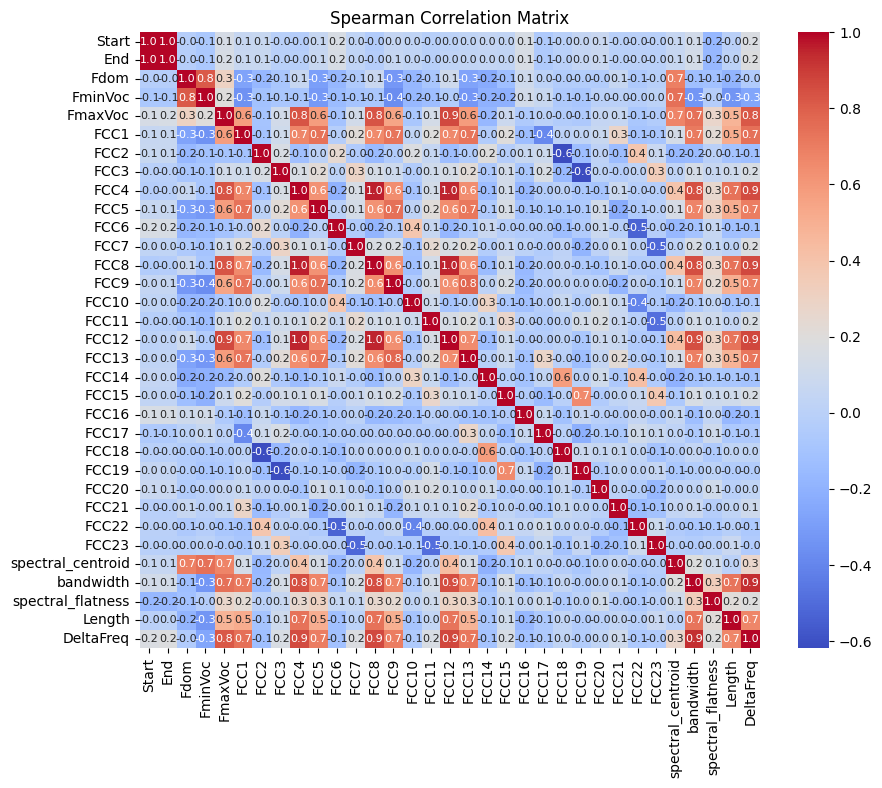

In [5]:
#Normality Test
normality_test = pg.multivariate_normality(only_features_scaled, alpha=0.05)
print(normality_test)

# Convert back to a DataFrame and assign column names
df_only_features_scaled = pd.DataFrame(only_features_scaled, columns=df_only_features.columns)
correlation_matrix = df_only_features_scaled.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

plt.title('Spearman Correlation Matrix')
plt.show()

## Remove variables with high correlation


In [6]:
# Define the threshold for high correlation
threshold = 0.85

# Create a mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Find the variables with high correlation
high_corr_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_vars.add(colname)

#high_corr_vars.add('FCC13')
print("Variables with high correlation:", high_corr_vars)

df_only_features_scaled = df_only_features_scaled.drop(columns=high_corr_vars, errors='ignore')

print(df_only_features_scaled.head())


Variables with high correlation: {'DeltaFreq', 'bandwidth', 'End', 'FCC12', 'FCC8'}
      Start      Fdom   FminVoc   FmaxVoc      FCC1      FCC2      FCC3  \
0 -1.738715  1.903697  1.452899  2.357093  0.870453 -1.083612  0.869500   
1 -1.639482 -0.515836 -0.633602 -0.158886  0.657196 -1.021309 -0.287907   
2 -1.540930 -2.237685  0.238369 -0.616337 -0.313280  1.665480 -2.505711   
3 -1.365574 -0.323350 -0.618031 -0.101705  0.799730  0.262366  0.779928   
4 -1.334309  0.074240  0.191656 -0.604901 -0.963822  0.700432 -1.503570   

       FCC4      FCC5      FCC6  ...     FCC17     FCC18     FCC19     FCC20  \
0  2.692758  0.807455 -1.622480  ... -0.214997 -0.040539 -0.222530 -0.080524   
1  0.326226  0.645554 -0.683976  ...  0.076819  1.058306 -0.114929  0.100908   
2 -1.082323  0.199223  2.071613  ... -1.639211 -1.595424  1.594475  0.190891   
3  0.625844  0.696609  0.573837  ... -0.404243 -0.194115  0.146399 -0.092895   
4 -0.656085 -0.211685  0.230617  ... -0.858075 -0.663291  1.02455

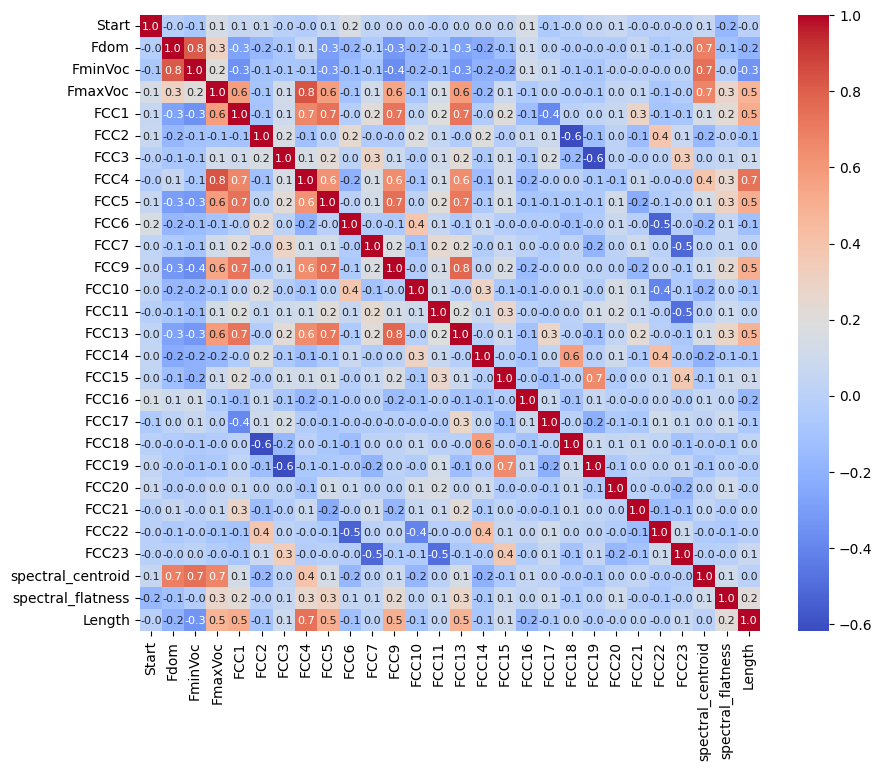

In [7]:
# Display the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))  # Set the size of the figure

# Calculate the correlation matrix using Spearman's method
correlation_matrix_reduced = df_only_features_scaled.corr(method='spearman')

# Generate the heatmap
sns.heatmap(correlation_matrix_reduced, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

# Show the plot
plt.show()

### Bartlett Test

In [8]:
# def self_calculate_bartlett_sphericity(data):
#     """
#     Perform Bartlett's test of sphericity.
    
#     Parameters:
#     data : dataframe
#         Data frame with scaled features for analysing the Bartlett's test

#     Returns:
#     chi_square_value : float
#         The chi-squared statistic.
#     p_value : float
#         The associated p-value for the test.
#     """

#     n_samples = data.shape[0]
#     corr_matrix = data.corr(method='spearman')
#     # Get the number of variables (p)
#     p = corr_matrix.shape[0]
    
#     # Calculate the determinant of the correlation matrix
#     corr_det = np.linalg.det(corr_matrix)
    
#     # Calculate the chi-square statistic using the formula
#     statistic = -np.log(corr_det) * (n_samples - 1 - (2 * p + 5) / 6)
    
#     # Calculate degrees of freedom
#     degrees_of_freedom = p * (p - 1) / 2
    
#     # Calculate the p-value from the chi-square distribution
#     p_value = chi2.sf(statistic, degrees_of_freedom)
    
#     return statistic, p_value



In [9]:
chi_square_value, p_value = self_calculate_bartlett_sphericity(df_only_features_scaled)
print(f"Results of the Bartlett Test are: Chi-square: {chi_square_value}, p-value: {p_value}")

Results of the Bartlett Test are: Chi-square: 8143.772137048364, p-value: 0.0


### KMO Test

KMO: 0.5046695810294096
Global KMO is not adequate: 0.5046695810294096. Variables with value less than 0.4 are removed.
...
...
Detecting variables with low KMO...


c:\Users\jonat\OneDrive - Universidad de Antioquia\Repositorios\Isolated_Observations\venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


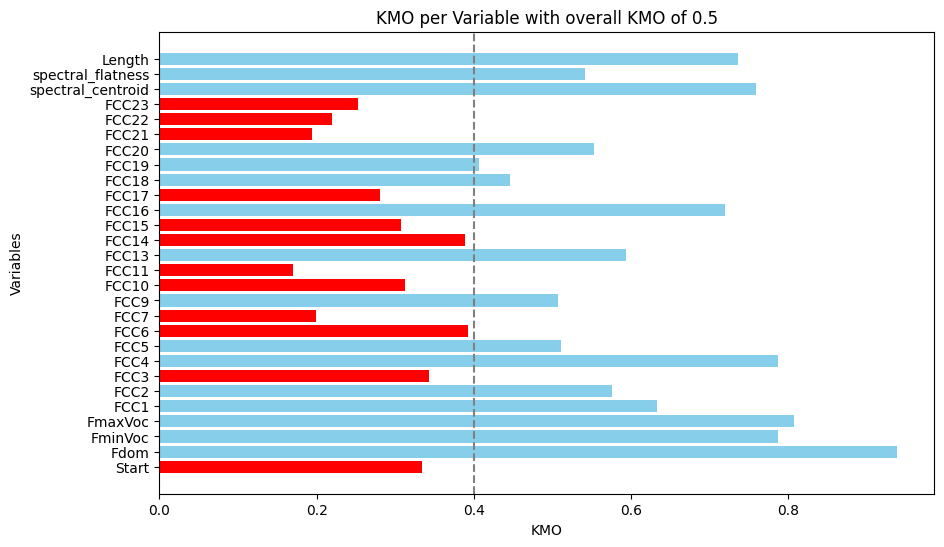

The variables to remove are: 
    Variable
0     Start
1      FCC3
2      FCC6
3      FCC7
4     FCC10
5     FCC11
6     FCC14
7     FCC15
8     FCC17
9     FCC21
10    FCC22
11    FCC23
Calculating the new KMO...
The new KMO value after removing variables is: 0.775936788752361


c:\Users\jonat\OneDrive - Universidad de Antioquia\Repositorios\Isolated_Observations\venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


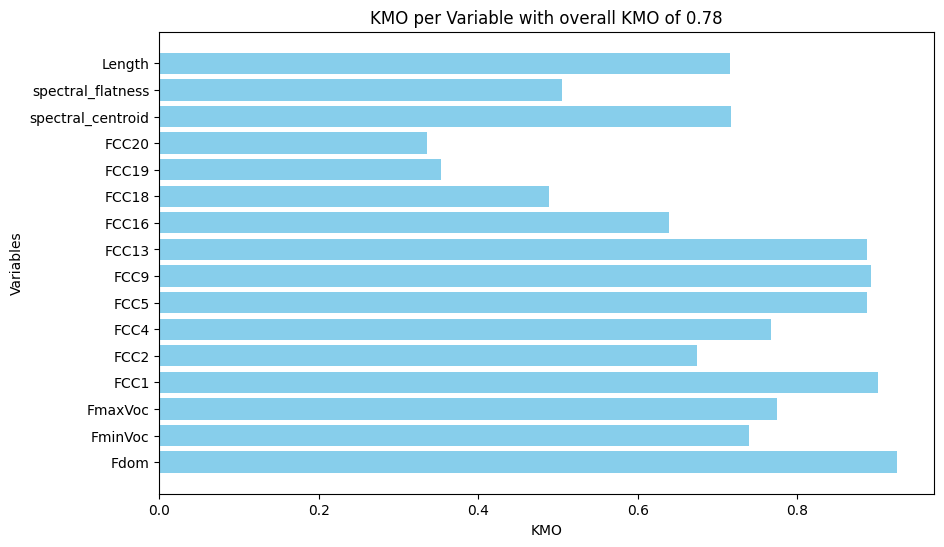

In [10]:
# KMO Test 
kmo_all, kmo_model = calculate_kmo(df_only_features_scaled)
print(f"KMO: {kmo_model}")

# Create a DataFrame with the KMO results for each variable
kmo_df = pd.DataFrame({'Variable': df_only_features_scaled.columns, 'KMO': kmo_all})
variables_to_remove = pd.DataFrame()

while kmo_model < 0.7:
    limit = 0.4
    print(f"Global KMO is not adequate: {kmo_model}. Variables with value less than {limit} are removed.")
    print("...")
    print("...")

    print("Detecting variables with low KMO...")

    # Filter the variables to keep
    variables_to_keep = kmo_df[kmo_df['KMO'] >= limit]['Variable']
    variables_to_remove = pd.concat([variables_to_remove, kmo_df[kmo_df['KMO'] < limit][['Variable']]], ignore_index=True)

    # Create a DataFrame after removing variables with low KMO
    df_filtered_afterKMO = df_only_features_scaled[variables_to_keep]

    # Determine colors for the bars
    colors = ['red' if kmo < limit else 'skyblue' for kmo in kmo_df['KMO']]

    # Visualize the KMO values
    plt.figure(figsize=(10, 6))
    plt.barh(kmo_df['Variable'], kmo_df['KMO'], color=colors)
    plt.xlabel('KMO')
    plt.ylabel('Variables')
    plt.title(f"KMO per Variable with overall KMO of {round(kmo_model, 2)}")
    plt.axvline(x=limit, color='gray', linestyle='--')
    plt.show()
    
    print(f'The variables to remove are: \n {variables_to_remove}')
        
    # Calculate the new KMO
    print("Calculating the new KMO...")
    kmo_all, kmo_model = calculate_kmo(df_filtered_afterKMO)
    kmo_df = pd.DataFrame({'Variable': df_filtered_afterKMO.columns, 'KMO': kmo_all})
    print(f"The new KMO value after removing variables is: {kmo_model}")
    
    if kmo_df[kmo_df['KMO'] < limit]['Variable'].empty:
        break 

# Final visualization of KMO values
plt.figure(figsize=(10, 6))
plt.barh(kmo_df['Variable'], kmo_df['KMO'], color='skyblue')
plt.xlabel('KMO')
plt.ylabel('Variables')
plt.title(f"KMO per Variable with overall KMO of {round(kmo_model, 2)}")
plt.show()


## Estimation of number of factors (Scree plot)

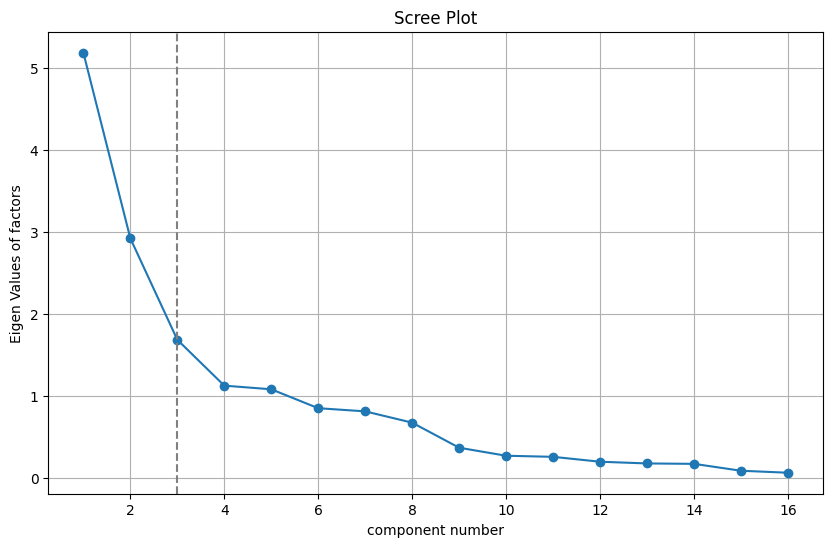

In [11]:
correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa = FactorAnalyzer(n_factors=correlation_matrix_afterKMO.shape[1], rotation=None, is_corr_matrix= True)
fa.fit(correlation_matrix_afterKMO)

# Obtain the eigenvalues
ev, v = fa.get_eigenvalues()

# scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, correlation_matrix_afterKMO.shape[1] + 1), ev, marker='o')
plt.xlabel('component number')
plt.ylabel('Eigen Values of factors')
plt.title('Scree Plot')
plt.axvline(x=3, color='gray', linestyle='--')
plt.grid()
plt.show()

## First Factor Analysis with Varimax Rotation

In [12]:
# Factor Analysis with varimax rotation 
fa1 = FactorAnalyzer(n_factors=3, rotation='varimax', method="minres", is_corr_matrix=True)

# Fit the FactorAnalyzer model on the correlation matrix after KMO filtering
# correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa1.fit(correlation_matrix_afterKMO)

# Obtain loadings
loadings = fa1.loadings_

# Create a DataFrame with the factor loadings
loadings_df = pd.DataFrame(loadings, columns=[f'Factor{i+1}' for i in range(loadings.shape[1])], index=df_filtered_afterKMO.columns)

print("Factor loadings:")
print(loadings_df)


Factor loadings:
                    Factor1   Factor2   Factor3
Fdom              -0.233523  0.850492 -0.006655
FminVoc           -0.324803  0.875914  0.057591
FmaxVoc            0.766373  0.546837  0.053164
FCC1               0.836313 -0.089138 -0.046076
FCC2              -0.076038 -0.195798  0.876497
FCC4               0.852488  0.255951 -0.037871
FCC5               0.833547 -0.084374  0.087971
FCC9               0.839034 -0.132682 -0.011003
FCC13              0.836216 -0.076775  0.025404
FCC16             -0.156434  0.080185  0.109615
FCC18             -0.008197 -0.021925 -0.706377
FCC19             -0.053576 -0.069035 -0.148520
FCC20              0.040148 -0.013302  0.009280
spectral_centroid  0.230117  0.900782  0.036497
spectral_flatness  0.314994  0.030011  0.058264
Length             0.661897 -0.081557 -0.078113


### Create Latent Variables

In [13]:
# Assign each variable to the factor with the highest loading
assignment = {}
for variable in loadings_df.index:
    max_loading_factor = loadings_df.loc[variable].abs().idxmax()
    max_loading_value = loadings_df.loc[variable, max_loading_factor]
    if round(abs(max_loading_value), 1) >= 0.35:
        assignment[variable] = (max_loading_factor, round(max_loading_value, 1))

# Create the latent variables (factors)
latent_variables = {f'Factor{i+1}': np.zeros(len(df_filtered_afterKMO)) for i in range(loadings.shape[1])}

for variable, (factor, weight) in assignment.items():
    latent_variables[factor] += weight * df_only_features[variable]

# Convert to DataFrame
df_latent = pd.DataFrame(latent_variables)

print("Latent Variables (factors):")
print(df_latent.head())


Latent Variables (factors):
        Factor1       Factor2   Factor3
3   8034.591272  18810.892536 -0.637257
8   4224.968672   9294.343669 -0.780443
11  3521.706555   7625.148061  1.166666
18  4313.475495   9675.642443  0.147324
19  3541.046429  11289.819537  0.470713


### Obtention of variables with good communalities for analysis

In [14]:
# Obtain the communalities
communalities = fa1.get_communalities()

# Create a DataFrame with the communalities
communalities_df = pd.DataFrame(communalities, index=df_filtered_afterKMO.columns, columns=['Communality'])

# Identify communalities less than 0.3
low_communalities = communalities_df[communalities_df['Communality'] < 0.3]

# Create a DataFrame without variables with communalities less than 0.3
variables_to_keep = communalities_df[communalities_df['Communality'] >= 0.3].index
df_filtered_high_communalities = df_filtered_afterKMO[variables_to_keep]

#print("Communalities:")
#print(communalities_df)

print("\nCommunalities less than 0.3:")
print(low_communalities)

df_filtered_high_communalities



Communalities less than 0.3:
                   Communality
FCC16                 0.042917
FCC19                 0.029695
FCC20                 0.001875
spectral_flatness     0.103516


,Fdom,FminVoc,FmaxVoc,FCC1,FCC2,FCC4,FCC5,FCC9,FCC13,FCC18,spectral_centroid,Length
0,1.903697,1.452899,2.357093,0.870453,-1.083612,2.692758,0.807455,0.860595,0.808929,-0.040539,2.029334,3.071524
1,-0.515836,-0.633602,-0.158886,0.657196,-1.021309,0.326226,0.645554,0.595543,0.793231,1.058306,-0.356162,-0.240990
2,-2.237685,0.238369,-0.616337,-0.313280,1.665480,-1.082323,0.199223,0.394372,-1.600794,-1.595424,-0.342963,-0.812113
3,-0.323350,-0.618031,-0.101705,0.799730,0.262366,0.625844,0.696609,0.481501,0.585396,-0.194115,-0.315065,0.253983
4,0.074240,0.191656,-0.604901,-0.963822,0.700432,-0.656085,-0.211685,-0.090062,-1.731896,-0.663291,-0.341456,-0.355215
...,...,...,...,...,...,...,...,...,...,...,...,...
332,-0.455735,-0.695885,-1.211023,-0.555034,0.333583,-0.862144,0.265004,0.083661,-1.931119,-0.089982,-1.226233,-0.317140
333,-0.467776,-0.711456,-1.211023,-0.083772,0.327906,-0.877757,-0.683720,-0.773228,-0.258723,-0.758217,-1.228752,-0.355215
334,-2.237685,-0.664744,-1.268204,-0.758730,-0.063038,-1.523600,0.560235,-0.658170,-1.050583,-0.213092,-1.238468,-0.850188
335,-0.479829,-0.742598,-1.211023,0.188150,2.211169,-0.861226,-2.166059,-0.167997,-0.906899,-1.854496,-1.257817,-0.240990


### Scree plot

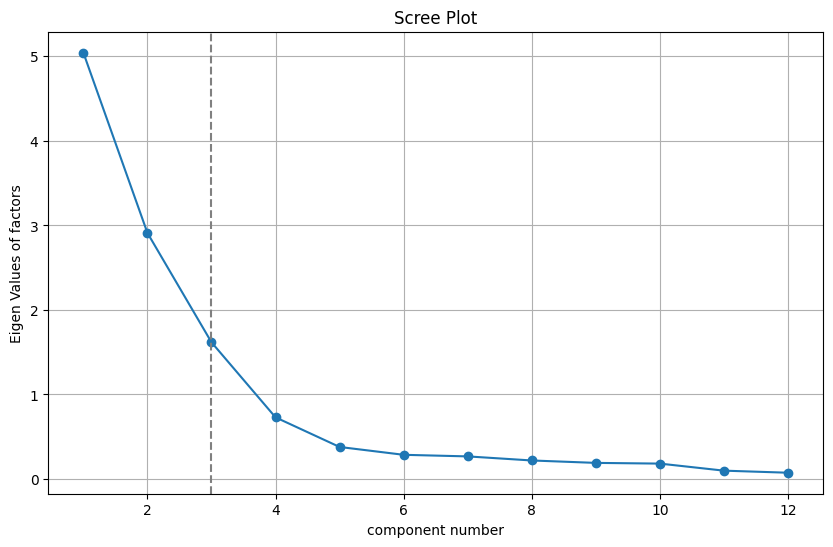

In [15]:
correlation_matrix_aftercommunalities = df_filtered_high_communalities.corr(method='spearman')
fa = FactorAnalyzer(n_factors=df_filtered_high_communalities.shape[1], rotation=None, is_corr_matrix= True)
fa.fit(correlation_matrix_aftercommunalities)

# Obtain the eigenvalues
ev, v = fa.get_eigenvalues()

# scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, correlation_matrix_aftercommunalities.shape[1] + 1), ev, marker='o')
plt.xlabel('component number')
plt.ylabel('Eigen Values of factors')
plt.title('Scree Plot')
plt.axvline(x=3, color='gray', linestyle='--')
plt.grid()
plt.show()

### KMO test after removal of variables with low communalities

In [16]:
kmo_all, kmo_model = calculate_kmo(df_filtered_high_communalities)
print(f"KMO: {kmo_model}")

KMO: 0.8063888798396548


### Second Factor Anlysis with Varimax Rotation

In [17]:
# Factor Analysis with varimax rotation 
fa2 = FactorAnalyzer(n_factors=3, rotation='varimax', method = "minres", is_corr_matrix= True)

#correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa2.fit(correlation_matrix_aftercommunalities)

# Obtain loadings
loadings = fa2.loadings_

# Create a Dataframe with the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'Factor{i+1}' for i in range(loadings.shape[1])], index=df_filtered_high_communalities.columns)

print("Loadings:")
print(loadings_df)

Loadings:
                    Factor1   Factor2   Factor3
Fdom              -0.203996  0.856604 -0.046626
FminVoc           -0.302738  0.885833  0.003992
FmaxVoc            0.783362  0.527261  0.020091
FCC1               0.836660 -0.114707 -0.042328
FCC2              -0.072535 -0.143029  0.981273
FCC4               0.859723  0.229559 -0.049124
FCC5               0.826976 -0.105543  0.073134
FCC9               0.837589 -0.156689 -0.004682
FCC13              0.831525 -0.103921  0.009003
FCC18             -0.015721 -0.058474 -0.639039
spectral_centroid  0.255859  0.892592 -0.016554
Length             0.655646 -0.104449 -0.073336


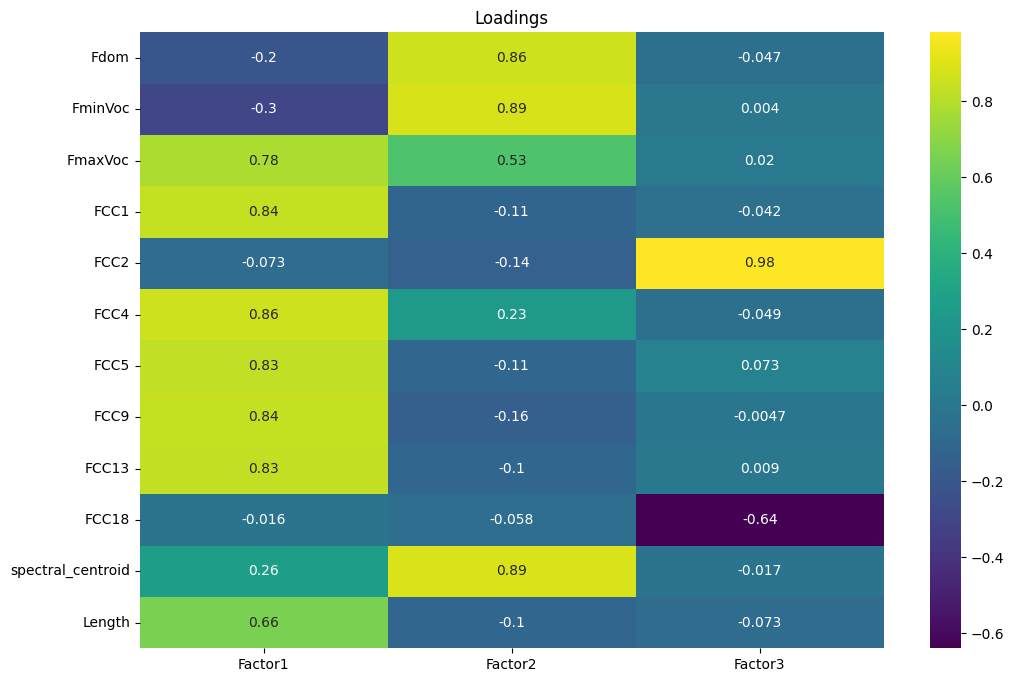

In [18]:
# Ploting the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, annot=True, cmap='viridis')
plt.title('Loadings')
plt.show()

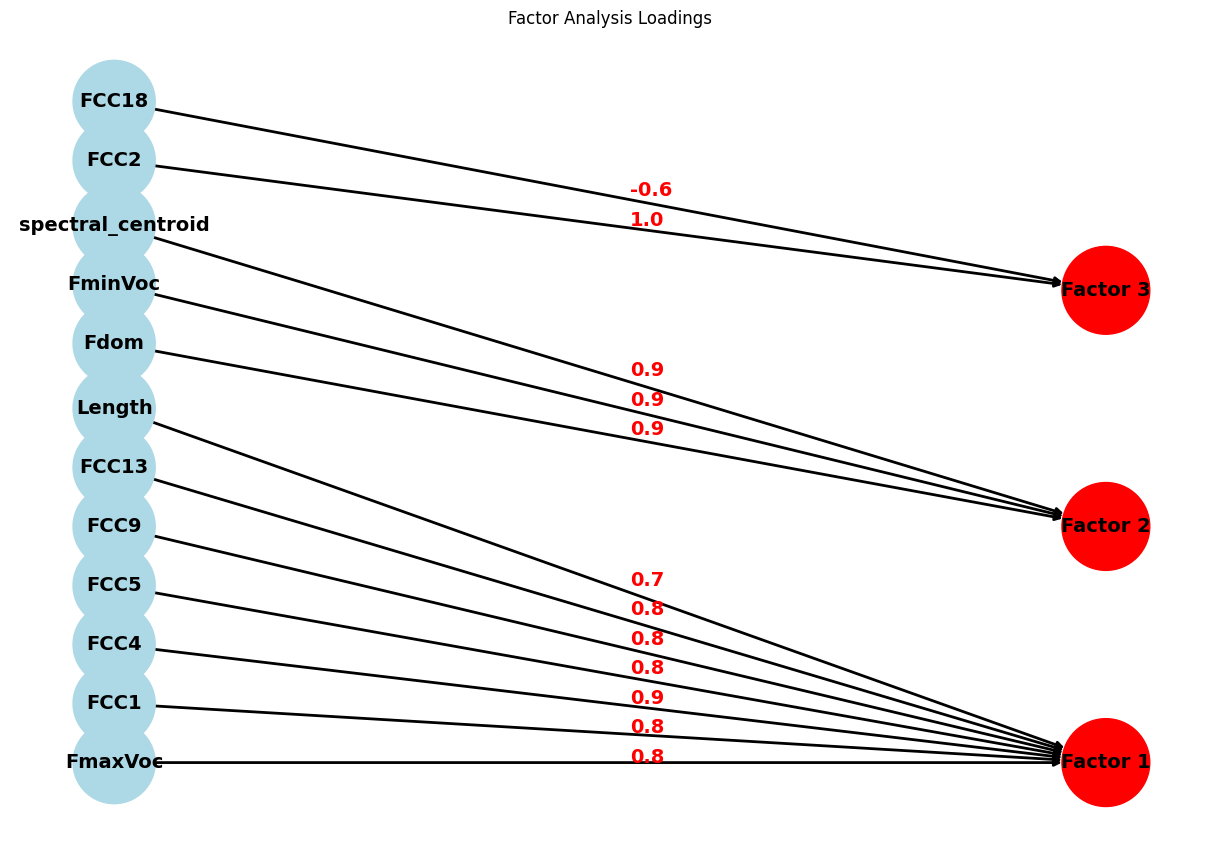

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_factor_loadings(loadings_df, factor_size=3000, variable_size=2000, font_size=12):
    # Create the graph
    G = nx.DiGraph()

    # Define the spacing between nodes
    space = 1  # Increase the spacing between variables of the same factor
    group_space_multiplier = 0.1  # Further reduce the extra space between different factor groups

    # Create a custom layout
    pos = {}
    y_offset_factors = 0  # Initial y offset for factors
    y_offset_variables = 0  # Initial y offset for variables

    # Assign each variable to the factor with the highest loading
    assignment = {}
    for variable in loadings_df.index:
        max_loading_factor = loadings_df.loc[variable].abs().idxmax()
        max_loading_value = loadings_df.loc[variable, max_loading_factor]
        if abs(max_loading_value) > 0.35:
            assignment[variable] = (max_loading_factor, max_loading_value)

    # Create factor nodes and assign initial positions
    factor_positions = {}
    factor_spacing = len(assignment) * space / len(loadings_df.columns)  # Adjust spacing
    for factor_index, factor in enumerate(loadings_df.columns):
        factor_name = f'Factor {factor_index + 1}'
        G.add_node(factor_name, color='red', size=factor_size)
        factor_positions[factor_name] = y_offset_factors
        pos[factor_name] = (1, y_offset_factors)
        y_offset_factors += factor_spacing

    # Position and add variables to the graph, grouping by factor
    for factor_index, factor in enumerate(loadings_df.columns):
        factor_name = f'Factor {factor_index + 1}'

        # Assign positions to variables assigned to this factor
        for variable, (assigned_factor, weight) in assignment.items():
            if assigned_factor == factor:
                pos[variable] = (0, y_offset_variables)
                G.add_node(variable, color='lightblue', size=variable_size)
                G.add_edge(variable, factor_name, weight=round(weight, 1))
                y_offset_variables += space

        # Add extra space between groups
        y_offset_variables += space * group_space_multiplier

    # Colors and sizes
    node_colors = [nx.get_node_attributes(G, 'color').get(node, 'lightblue') for node in G.nodes()]
    node_sizes = [nx.get_node_attributes(G, 'size').get(node, variable_size) for node in G.nodes()]
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='black', width=2, font_size=font_size, font_color='black', font_weight='bold')

    # Edge labels with one decimal place
    for (u, v), weight in edge_labels.items():
        x_pos = (pos[u][0] + pos[v][0]) / 2 + 0.02  # Horizontal adjustment
        y_pos = (pos[u][1] + pos[v][1]) / 2
        plt.text(x_pos, y_pos, f'{weight:.1f}', color='red', fontsize=font_size, fontweight='bold')

    plt.title('Factor Analysis Loadings')
    plt.show()

# Call the function to plot with a custom font size
plot_factor_loadings(loadings_df, factor_size=4000, variable_size=3500, font_size=14)

### Create new dataset only with the latent variables and two other variables.

In [20]:
# Extract the 'bandwidth' variable
bandwidth_df = df_only_features[['bandwidth']]
spectral_flatness_df = df_only_features[['spectral_flatness']]
Length_df = df_only_features[['Length']]
DeltaFreq_df = df_only_features[['DeltaFreq']]
spectral_centroid_df = df_only_features[['spectral_centroid']] 


if dataset == 'Automatic_Labeling_Kyoogu/':
    df_reduced2 = pd.concat([df_latent, Length_df, DeltaFreq_df], axis=1)
elif dataset == 'Dataset_1':
    df_reduced2 = pd.concat([df_latent, bandwidth_df, spectral_centroid_df], axis=1)
else:
    df_reduced2 = pd.concat([df_latent, spectral_flatness_df, DeltaFreq_df], axis=1)



# Concatenate the latent variables with 'bandwidth'
df_reduced2['Specie_ID'] = df_filtered['Specie ID']


print("Combined DataFrame:")
print(df_reduced2.head())


outputfile = 'reduced_dataframe_FA2.xlsx'
df_reduced2.to_excel(data_path+dataset+outputfile,index=True)


Combined DataFrame:
        Factor1       Factor2   Factor3  spectral_flatness    DeltaFreq  \
3   8034.591272  18810.892536 -0.637257           0.445569  4198.974609   
8   4224.968672   9294.343669 -0.780443           0.486660  2347.119141   
11  3521.706555   7625.148061  1.166666           0.649695   279.931641   
18  4313.475495   9675.642443  0.147324           0.434054  2433.251953   
19  3541.046429  11289.819537  0.470713           0.411317   366.064453   

                   Specie_ID  
3           Coereba flaveola  
8   Leptopogon superciliaris  
11                 Hyloxalus  
18  Leptopogon superciliaris  
19                 Hyloxalus  
